In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [121]:
def sanity_check(matrix):
    if not np.allclose(np.linalg.norm(matrix,axis=1),1):
        raise ValueError("At least one non unit vector")
    return True

def project_and_calc_dist(X,Y,theta,p):
    
    x_proj = np.dot(X, theta.T)
    y_proj = np.dot(Y, theta.T)
    #N,d = X.shape
    qs = np.linspace(0,1,100)
    xp_quantiles = np.quantile(x_proj, qs, axis=0, method="inverted_cdf")
    yp_quantiles = np.quantile(y_proj, qs, axis=0, method="inverted_cdf")

    
    dist_p = np.abs(xp_quantiles - yp_quantiles)**p

    #mu = np.mean(dist_p)
    #var  =np.var(dist_p)

    #print(mu*mu/var)
    #print(mu/var)
    return dist_p


def activation(vector):
    return np.exp(vector)/np.exp(vector).sum()


def sample_theta(X,num_smaples=10):
    _ , d = X.shape
    theta = np.random.randn(num_smaples,d)
    theta_norm = np.linalg.norm(theta, axis=1)
    theta_normed = theta / theta_norm[:, np.newaxis]
    return theta_normed


In [122]:
mx = np.array([1,1,3,0,0])
Var_X = np.diag([1,2,3,4,5])
my = np.array([0,0,1,0,0])
my=mx
Var_Y = np.eye(5)
Var_Y = Var_X
N= 10000
X_N = np.random.multivariate_normal(mx,Var_X,size=N)
Y_N = np.random.multivariate_normal(my,Var_Y,size=N)
THETA = sample_theta(X_N,num_smaples=1000)
x_proj = np.dot(X_N,THETA.T)
y_proj = np.dot(Y_N,THETA.T)

In [4]:
x_proj.shape

(10000, 1000)

In [123]:
Var_X_est = pd.DataFrame(X_N).cov().values
mx_est = np.mean(X_N,axis=0)
projected_var_x = (np.linalg.norm(mx_est,axis=0)**2/5 + np.trace(Var_X_est)/5)
true_projected_varx = (np.linalg.norm(mx,axis=0)**2/5 + np.trace(Var_X)/5)
print("True Var after Projection: \n {:.4f}".format(true_projected_varx))
print("Estimated based on X: \n {:.6f}".format(projected_var_x))
Var_X_after_proj = np.var(x_proj,axis=1).mean()
print("Estimated Var after Projection: \n {:.6f}".format(Var_X_after_proj))

True Var after Projection: 
 5.2000
Estimated based on X: 
 5.197892
Estimated Var after Projection: 
 5.239509


In [124]:
Var_Y_est = pd.DataFrame(Y_N).cov().values
my_est = np.mean(Y_N,axis=0)
projected_var_y = (np.linalg.norm(my_est,axis=0)**2/5 + np.trace(Var_Y_est)/5)
true_projected_vary = (np.linalg.norm(my,axis=0)**2/5 + np.trace(Var_Y)/5)
print("True Var after Projection: \n {:.4f}".format(true_projected_vary))
print("Estimated based on Y_N: \n {:.6f}".format(projected_var_y))
Var_Y_after_proj = np.var(y_proj,axis=1).mean()
print("Estimated Var after Projection: \n {:.6f}".format(Var_Y_after_proj))

True Var after Projection: 
 5.2000
Estimated based on Y_N: 
 5.211512
Estimated Var after Projection: 
 5.255631


##### Idea

get a distribution for each quantile to then build the difffernce for each distribution 

Example: 

$q_X \sim MVN(\mu_{qx},\Sigma_{qx})$
$q_Y \sim MVN(\mu_{qy},\Sigma_{qy})$


$\sum_{i=0}^{qs}|q_X[i]-q_Y[i]|^{2}$ should be RV with Gamma Distribution.

Since $Z_i = q_X[i]-q_Y[i] \sim \mathcal{N}$  and $|\tilde{Z}_{i}| = |Z_{i}-\mathbb{E}[Z_{i}]| \sim HN(\sigma^{2}) $

and $|\tilde{Z}_{i}|^{2} \sim \Gamma(0.5,\beta_{i})$

Problem will be $\beta$ 

In [155]:
#### Compute quantiles of Projections for each column 

qs = np.linspace(0,1,1000)

x_proj_q = np.quantile(x_proj,qs,axis=0)
y_proj_q = np.quantile(y_proj,qs,axis=0)

TRACE_X_est = np.trace(Var_X_est)/5
TRACE_Y_est = np.trace(Var_Y_est)/5

print('Comparison to var of projection')
print(np.var(x_proj_q,axis=1).mean()+TRACE_X_est)
print(np.var(y_proj_q,axis=1).mean()+TRACE_Y_est)


print('Actual sample Variance')
print(np.var(x_proj_q,axis=1).mean())
print(np.var(y_proj_q,axis=1).mean())


Comparison to var of projection
5.268866218420608
5.287639518178684
Actual sample Variance
2.2645769409700716
2.2994280421547355


3.06857557097268


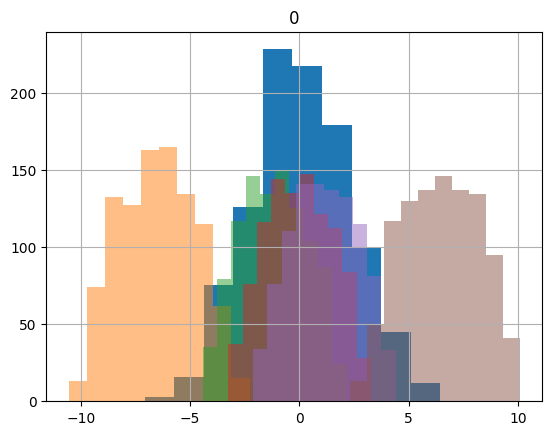

In [178]:
# for k in [0,250,500,750,999]:
#     print(pd.DataFrame(x_proj_q).iloc[k,:].var())

print(np.var(x_proj_q,axis=0).mean())

pd.DataFrame(np.random.normal(0,2.2645,1000)).hist()

for k in [0,250,500,750,999]:
    pd.DataFrame(x_proj_q).iloc[k,:].hist(alpha=0.5)

##### Important (Maybe)

<Axes: >

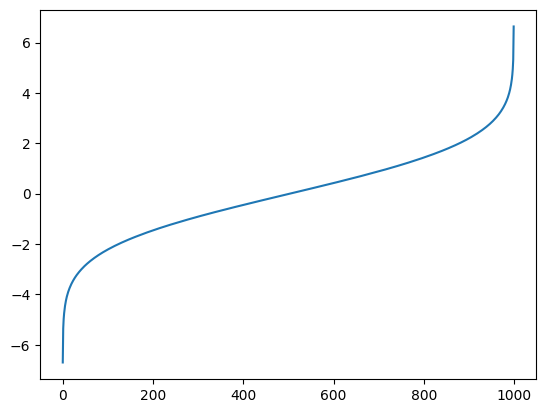

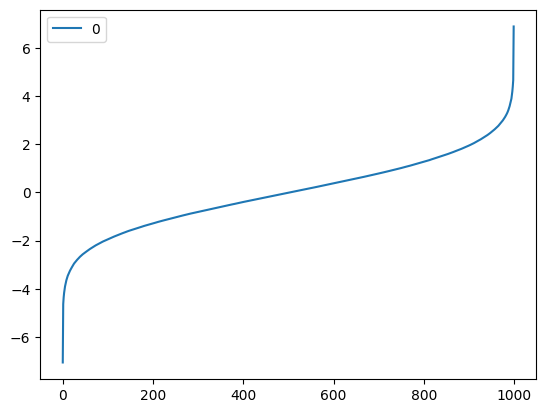

In [203]:
pd.DataFrame(y_proj_q).mean(axis=1).plot()

#####################################################
###Here we have a normal distirbution with value like sorted projection
pd.DataFrame(np.quantile(np.random.normal(0,2.3**0.5,100000),qs)).plot()



array([[<Axes: title={'center': '0'}>]], dtype=object)

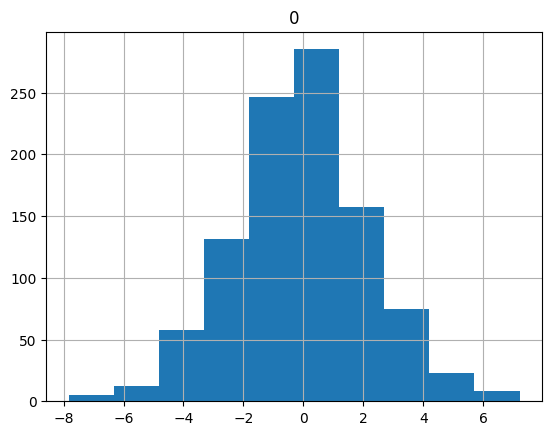

In [154]:
pd.DataFrame(np.random.normal(0,5.2**0.5,1000)).hist()

In [126]:
Q_mean = np.mean(x_proj_q,axis=1)-np.mean(y_proj_q,axis=1)
Q_var = np.var(x_proj_q,axis=1)+np.var(y_proj_q,axis=1)


diff_quantiles = x_proj_q - y_proj_q


# diff_quantiles_normalised = np.zeros((len(qs),1000))
# for t in range(len(qs)):
#     diff_quantiles_normalised[t,:] = diff_quantiles[t,:] - Q_mean[t]

# print(diff_quantiles.shape)
# ##### Verteilung pro q 

Diff_2  = pd.DataFrame(np.abs(diff_quantiles)**2)


a_vals = []
b_vals = []

for t in range(len(qs)):
    m = Diff_2.iloc[t,:].mean()
    v = Diff_2.iloc[t,:].var()
    # print(t)
    # print("###########")
    # print("a", m**2/v)
    a_vals.append(m**2/v)
    # print('b', v/m)
    b_vals.append(v/m)

### mean is actually near a*b of fitted Gamma to output
Diff_2.mean(axis=1)



0     0.466032
1     0.007993
2     0.005876
3     0.004656
4     0.003798
        ...   
95    0.003725
96    0.004696
97    0.005841
98    0.007611
99    0.414223
Length: 100, dtype: float64

<Axes: >

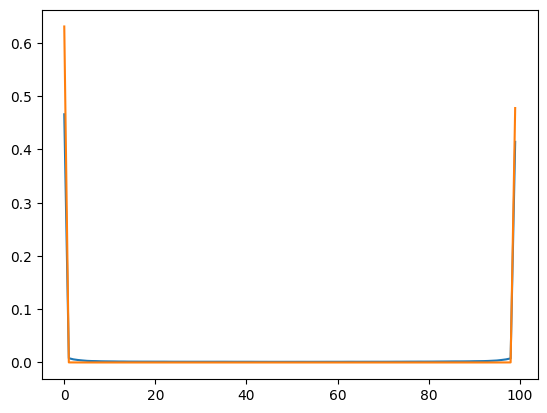

In [127]:
Diff_2.mean(axis=1).plot()
Diff_2.var(axis=1).plot()

In [128]:
tmp_m = Diff_2.mean(axis=1).mean()
tmp_v = Diff_2.var(axis=1).mean()
a_quantile =tmp_m**2/tmp_v
b_quantile = tmp_v/tmp_m

In [38]:
#np.abs(Q_mean)**2+2*np.abs(Q_mean)


0    0.010701
dtype: float64


<Axes: ylabel='Density'>

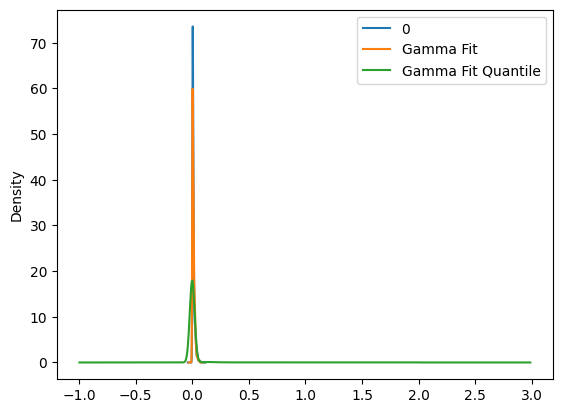

In [129]:
fig2,ax2  = plt.subplots()

W2 = pd.DataFrame(project_and_calc_dist(X_N,Y_N,THETA,p=2).mean(axis=0))

print(W2.mean())
W2.plot.kde(ax=ax2)

b= W2.var()/W2.mean()
a = W2.mean()**2/W2.var()


#pd.DataFrame(np.random.noncentral_chisquare(2,1,1000),columns=['Non central chi squared']).plot.kde(ax=ax2)

pd.DataFrame(np.random.gamma(a,b,1000),columns=['Gamma Fit']).plot.kde(ax=ax2)

pd.DataFrame(np.random.gamma(a_quantile,b_quantile,1000),columns=['Gamma Fit Quantile']).plot.kde(ax=ax2)


In [130]:
print(a,b)

0    1.104321
dtype: float64 0    0.009691
dtype: float64


In [101]:
(Diff_2.mean(axis=1)**2/Diff_2.var(axis=1)).mean()

np.float64(0.4624869834853776)

### IF X =Y

Then we have $X^{T}\theta = Y^{T}\theta \sim \mathcal{N}(0,d^{-1}(||\mu||^{2}+tr(\Sigma)))$


$(X-Y)\theta \sim mathcal{N}(....)$

Problem SWD sorts $X^{T}\theta$ and $Y^{T}\theta$ first

Claim:
The sorting, quantile caluclation reduces the variance by $tr(\Sigma)$ and changes mean (not over each quantile) but within qunatile (example q=0.01 mean negative -6), (quantile q=0.99 6+)


However each quantile follows a normal distribution $Z(q) = F^{-1}_{T^{\theta}_{\#}}(q) \sim \mathcal{N}$

Question: which mean has $Z(q)$
Then 

In [131]:

print(a*b)
(a*b**2)

0    0.010701
dtype: float64


0    0.000104
dtype: float64

In [280]:
(1/2/(1/diff_quantiles_normalised.var(axis=1))).sum()

np.float64(140.35069556136264)

In [193]:
#### ql times L matrix
diff_quantiles = x_proj_q - y_proj_q

(np.var(x_proj_q,axis=1)+np.var(y_proj_q,axis=1)).mean()

diff_quantiles.var(axis=1)

array([3.95005431, 2.93186878, 2.88045703, 2.88111364, 2.87952402,
       2.87241521, 2.87040395, 2.87157463, 2.86478876, 2.85025021,
       2.84545007, 2.84207816, 2.83245767, 2.83016088, 2.82586935,
       2.82421098, 2.82142926, 2.81568365, 2.81632208, 2.80992566,
       2.8007102 , 2.79261665, 2.79192516, 2.79456058, 2.79067915,
       2.7868046 , 2.78370254, 2.77825569, 2.7712362 , 2.77098077,
       2.77023468, 2.76718232, 2.7654975 , 2.75883996, 2.75595509,
       2.75327431, 2.75540853, 2.75186241, 2.75118933, 2.75102743,
       2.75266897, 2.75153251, 2.74916328, 2.7480474 , 2.74970595,
       2.75066587, 2.7508124 , 2.74883728, 2.74894791, 2.7468881 ,
       2.74462822, 2.74843268, 2.74364515, 2.74650424, 2.74508627,
       2.74369939, 2.7390572 , 2.73721715, 2.73572513, 2.73640798,
       2.73966866, 2.74052842, 2.73582344, 2.73919158, 2.73864255,
       2.74013341, 2.74064078, 2.743398  , 2.74663901, 2.74998923,
       2.75244106, 2.76041585, 2.76009258, 2.76501139, 2.76430

### $\Gamma$-Process

$X_{t}=X_{t-1} + \epsilon_{t}$ with $\epsilon_{t} \sim \Gamma(\alpha,\beta)$

with random changes Gamma distribution at $t=100,200$

array([<Axes: title={'center': 'Hist of Process'}>], dtype=object)

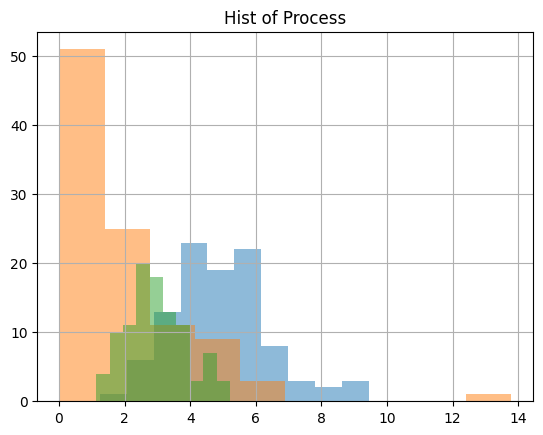

In [147]:
Gamma1 =np.random.gamma(10,0.5,100)
Gamma2 = np.random.gamma(1,2,100)
Gamma3 = np.random.gamma(10,0.3,100)

Process = pd.DataFrame(np.hstack((Gamma1,Gamma2,Gamma3)),columns=['Hist of Process'])

fig, ax = plt.subplots()
Process[:100].hist(ax=ax,alpha=0.5)
Process[100:200].hist(ax=ax,alpha=0.5)
Process[200:].hist(ax=ax,alpha=0.5)


<Axes: >

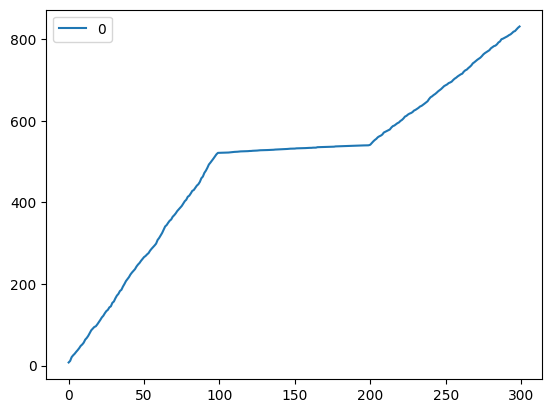

In [138]:
pd.DataFrame(np.hstack((Gamma1,Gamma2,Gamma3))).cumsum().plot()